Decoder Transformer V.4 based on PyTorch.

In this notebook, we attempt to train the model that includes more than 4 attributes.

In [1]:
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")

We're running Colab


In [2]:
if IN_COLAB:
    # Mount the Google Drive at mount
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os
    drive_root = mount + "/MyDrive/Proposal"

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root

Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/MyDrive/Proposal  exists.

Colab: Changing directory to  /content/gdrive/MyDrive/Proposal
/content/gdrive/MyDrive/Proposal


In [3]:
!nvidia-smi

Sat Jun 17 03:56:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries

In [4]:
import json
import matplotlib.pyplot as plt
import multiprocessing
import torch.multiprocessing as mp
from multiprocessing import Process, Queue
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import threading

# Hyperparameters

In [5]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 14 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
n_head = 8
n_layer = 16
dropout = 0.2
# ------------

random_state = 2023
torch.manual_seed(random_state)
np.random.seed(random_state)

debug = False

model_path = "model8.pt"

# Util Functions

In [6]:
def binning(df, column, bin_edges, labels=None):
    """
    Function that performs binning for a numeric column in a Pandas dataframe.
    df: Pandas dataframe
    column: name of the numeric column to be binned
    bin_edges: list of bin edges to use
    labels: list of labels to assign to the bins
    """
    # Use the Pandas cut function to bin the column
    df[column + '_binned'] = pd.cut(df[column], bins=bin_edges, labels=labels)

    return df

In [7]:
def compare_attributes(df1, df2, columns_to_plot=None, legend_labels=None):
    if columns_to_plot is None:
        columns_to_plot = df1.columns

    # Iterate over each column in the dataframes
    for i, col in enumerate(columns_to_plot):
        # Create a new figure and axis object for each attribute
        fig, ax = plt.subplots()

        # Get the frequencies for each unique value in the column
        freq1 = df1[col].value_counts()
        freq2 = df2[col].value_counts()

        # Combine the frequencies into a single dataframe
        freq_df = pd.concat([freq1, freq2], axis=1, keys=['df1', 'df2'])

        # Plot the frequencies as a bar chart
        freq_df.plot(kind='bar', ax=ax, rot=0)

        # Set the title for the subplot
        ax.set_title(col)

        # Add a legend to the plot
        plt.legend(legend_labels)

        # Show the plot
        plt.show()


In [8]:
def count_unique_elements(my_list):
    # Create an empty list to store unique elements
    unique_list = []

    # Loop through each element in the list
    for element in my_list:
        # Check if the element is not already in the unique list
        if element not in unique_list:
            # If it's not, add it to the unique list
            unique_list.append(element)
            unique_list.sort()
            max_vocab = max(unique_list)

    # Return the length of the unique list and the unique list itself
    return len(unique_list), unique_list, max_vocab

In [9]:
# Convert the model output into a pandas dataframe
def create_dataframe(data_list, num_columns, header=None):
    # Calculate the number of rows needed based on the length of the data_list
    # and the specified number of columns
    num_rows = len(data_list) // num_columns + (len(data_list) % num_columns > 0)

    # Create a 2D array with the data_list values
    data_array = [data_list[i:i+num_columns] for i in range(0, len(data_list), num_columns)]

    # Add empty values to the end of each row to ensure all rows have the same length
    for i in range(len(data_array)):
        while len(data_array[i]) < num_columns:
            data_array[i].append(None)

    # Create a Pandas dataframe from the 2D array
    df = pd.DataFrame(data_array, columns=header)

    return df


In [10]:
def flatten_list(nested_list):
    flat_list = []
    for inner_list in nested_list:
        for element in inner_list:
            flat_list.append(element)

    return flat_list

In [11]:
## Train and Test Splits
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))

    if debug == True:
        print(f"ix: {ix}")

    x = torch.stack([data[i:i+block_size] for i in ix])

    if debug == True:
        print(f"x: {x}")

    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    if debug == True:
        print(f"y: {y}")

    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):

            if debug == True:
                print(f"k: {k}")

            X, Y = get_batch(split)

            if debug == True:
                print(f"X: {X}")
                print(f"Y: {Y}")

            logits, loss = model(X, Y)

            if debug == True:
                print(f"logits: {logits}")
                print(f"loss: {loss}")

            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [12]:
def plot_attribute_distribution(df):
    # check the distribution of each attribute
    # iterate over columns in dataframe
    for col in df.columns:
        # count the frequency of each attribute
        value_counts = df[col].value_counts()
        # create a bar chart of the frequency of each attribute
        plt.figure()
        plt.bar(value_counts.index, value_counts.values)
        plt.title(col)
        plt.show()

In [13]:
def print_uniq_val(df):
    # Create an empty dictionary to store unique values for each column
    unique_values_dict = {}

    # Iterate through each column of the dataframe
    for column_name in df.columns:
        # Get the unique values of the current column
        unique_values = df[column_name].unique().tolist()

        # Sort the unique values
        unique_values.sort()

        # Store the sorted unique values in the dictionary
        unique_values_dict[column_name] = unique_values

    # Print the unique values for each column
    for column_name, unique_values in unique_values_dict.items():
        print(f"Column name: {column_name}")
        print(f"Unique values: {unique_values}")
        print(f"Total unique values: {len(unique_values)}")
        print("\n")

In [14]:
def random_sample(df, n, random_state):
    """
    Returns a tuple of two dataframes:
    the first dataframe contains n randomly sampled rows from the input dataframe without replacement,
    the second dataframe contains the remaining rows that were not sampled.
    """
    sample_df = df.sample(n=n, replace=False, random_state=random_state)
    remaining_df = df.drop(sample_df.index)

    return sample_df, remaining_df


In [15]:
## Standardization
# transform numerical features (normalization)
def transform_continuous(dataset, continuous_cols):
    """
    dataset: Raw dataset not yet normalized

    continuous_cols: a list of continuous columns
    """

    # scaler = MinMaxScaler(feature_range = (0, 1))

    scaler = skp.StandardScaler()

    columns_to_scale = continuous_cols
    scaled_array = scaler.fit_transform(dataset.loc[:, columns_to_scale])
    df_scaled = pd.DataFrame(scaled_array, columns=scaler.get_feature_names_out())
    return df_scaled


# inverse transform normalized vectors
def inverse_transform_continuous(original_dataset, synthetic_dataset, col_list):
    # scaler = skp.MinMaxScaler(feature_range = (0, 1))
    scaler = skp.StandardScaler()
    columns_to_normalize = col_list
    scaler.fit(original_dataset[columns_to_normalize])
    fake_attribute = scaler.inverse_transform(synthetic_dataset[scaler.get_feature_names_out()])
    df = pd.DataFrame(fake_attribute, columns = columns_to_normalize)

    return df

# Load train, test, validation sets

In [18]:
test_df = pd.read_csv('data/test_df.csv')
train_df = pd.read_csv('data/train_df.csv')
valid_df = pd.read_csv('data/valid_df.csv')

In [19]:
print(f"test: {len(test_df)}, train: {len(train_df)}, valid: {len(valid_df)}")

test: 120904, train: 435254, valid: 48361


In [28]:
# get the elements of the dataframe as a list
train_list = train_df.values.flatten().tolist()
valid_list = valid_df.values.flatten().tolist()

# print the resulting list
print("Example of the train list:")
print(train_list[:20])
print("#--------------------#")
print("Example of the valid list:")
print(valid_list[:20])
print("#--------------------#")


train_data = torch.tensor(train_list, dtype=torch.long)
val_data = torch.tensor(valid_list, dtype=torch.long)

Example of the train list:
[3002, 2016, 1001, 5006, 6001, 7001, 8001, 9001, 10000, 4001, 11003, 12002, 15, 13001, 3004, 2042, 1001, 5003, 6001, 7001]
#--------------------#
Example of the valid list:
[3001, 2010, 1002, 5006, 6001, 7003, 8005, 9003, 10000, 4002, 11003, 12002, 36, 13001, 3001, 2010, 1002, 5006, 6001, 7003]
#--------------------#


In [20]:
# Load max_vocab setting
with open('max_vocab_model8.json', 'r') as openfile:
    json_object = json.load(openfile)

vocab_size = json_object['vocab_size']
max_vocab = json_object['max_vocab']
print(f"vocab_size: {vocab_size}, max_vocab: {max_vocab}")

vocab_size: 246, max_vocab: 13009


# Network Components

## Head

In [21]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

## Multi-head Attention

In [22]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

## Feed forward

In [23]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

## Block

In [24]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

## Bigram Model

In [25]:
# very simple bigram model
class BigramModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token
        # from a lookup table
        self.token_embedding_table = nn.Embedding(max_vocab+1, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, max_vocab+1)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)

        if debug == True:
            print(f"tok_emb: {tok_emb}")

        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            if debug == True:
                print(f"logits: {logits}")
                print(f"targets: {targets}")
                print(f"logits shape: {logits.shape}")
                print(f"targets shape: {targets.shape}")
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# Training Phase

## Train model

In [26]:
model = BigramModel()
# model.load_state_dict(torch.load(model_path))
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

6.511826 M parameters


In [29]:
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 9.5944, val loss 9.5939
step 100: train loss 1.2838, val loss 1.2832
step 200: train loss 1.1178, val loss 1.1209
step 300: train loss 1.0815, val loss 1.0824
step 400: train loss 1.0613, val loss 1.0616
step 500: train loss 1.0615, val loss 1.0649
step 600: train loss 1.0473, val loss 1.0491
step 700: train loss 1.0438, val loss 1.0440
step 800: train loss 1.0382, val loss 1.0317
step 900: train loss 1.0379, val loss 1.0350
step 1000: train loss 1.0315, val loss 1.0306
step 1100: train loss 1.0316, val loss 1.0343
step 1200: train loss 1.0209, val loss 1.0296
step 1300: train loss 1.0231, val loss 1.0216
step 1400: train loss 1.0219, val loss 1.0254
step 1500: train loss 1.0264, val loss 1.0312
step 1600: train loss 1.0336, val loss 1.0295
step 1700: train loss 1.0238, val loss 1.0199
step 1800: train loss 1.0236, val loss 1.0229
step 1900: train loss 1.0128, val loss 1.0204
step 2000: train loss 1.0161, val loss 1.0180
step 2100: train loss 1.0174, val loss 1.0182


## Save model

In [30]:
# Save model
torch.save(m.state_dict(), model_path)

## Load model

In [ ]:
# Load model
model = BigramModel()
model = model.to(device)
# model.load_state_dict(torch.load(model_path))

# if using CPU only
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


# model.eval()

RuntimeError: ignored

# Generate from the model

## Parallel generation

In [ ]:
print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  2


In [ ]:
def generate_data(model, generated_size, block_size, results_queue, initialized_token=0):
    generated_size = generated_size
    context = torch.tensor(([[initialized_token]]), dtype=torch.long, device=device)
    # context = torch.zeros((1, 1), dtype=torch.long, device=device)
    r = (block_size*generated_size) # including the zero initial state
    out = model.generate(context, max_new_tokens=r)[0].tolist()

    # ignore the first block as it include the zero initial state
    fin = out[4:]

    # return out
    results_queue.put(fin) # for multiprocessing Queue


In [ ]:
# torch.zeros((1, 1), dtype=torch.long, device=device)

In [ ]:
# torch.tensor(([[1]]), dtype=torch.long, device=device)

In [ ]:
%%time
if __name__ == '__main__':

    # mp.set_start_method('spawn')

    # Create a multiprocessing Queue object to hold the results
    results_queue = Queue()

    # Create two process objects and pass arguments to my_func
    p1 = Process(target=generate_data, args=(model, 1000, 4, results_queue, 0))
    p2 = Process(target=generate_data, args=(model, 1000, 4, results_queue, 10))
    p3 = Process(target=generate_data, args=(model, 1000, 4, results_queue, 20))
    p4 = Process(target=generate_data, args=(model, 1000, 4, results_queue, 30))

    # Start the processes
    p1.start()
    p2.start()
    p3.start()
    p4.start()

    # Wait for the processes to finish
    p1.join()
    p2.join()
    p3.join()
    p4.join()

    # Get the results from the Queue
    results = []
    while not results_queue.empty():
        results.append(results_queue.get())
    print(f"Results: {results}")

Results: []
CPU times: user 44 ms, sys: 6.98 ms, total: 51 ms
Wall time: 194 ms


In [ ]:
type(results)

list

In [ ]:
len(results)

0

In [ ]:
len(results[0])

In [ ]:
print(results[0][:12])
print(results[1][:12])
print(results[2][:12])
print(results[3][:12])

In [ ]:
print(results[0][-12:])
print(results[1][-12:])
print(results[2][-12:])
print(results[3][-12:])

In [ ]:
gen = []
gen.append(flatten_list(results))

In [ ]:
print(gen)
print(len(gen))

[[28, 302, 402, 201, 32, 302, 402, 201, 42, 302, 402, 201, 24, 302, 403, 201, 58, 301, 402, 201, 32, 301, 409, 201, 29, 302, 403, 201, 1, 301, 400, 202, 6, 301, 400, 201, 50, 302, 400, 201, 81, 302, 400, 202, 39, 302, 403, 202, 43, 302, 400, 202, 13, 301, 400, 201, 55, 302, 401, 201, 46, 302, 401, 202, 39, 304, 401, 202, 3, 301, 400, 202, 23, 301, 402, 202, 47, 302, 400, 202, 44, 302, 403, 202, 23, 301, 400, 202, 10, 301, 400, 202, 26, 302, 403, 202, 24, 301, 402, 201, 25, 301, 402, 201, 19, 301, 403, 202, 40, 302, 400, 201, 63, 302, 401, 202, 22, 301, 400, 202, 12, 301, 400, 201, 3, 301, 400, 201, 13, 300, 400, 202, 42, 302, 403, 202, 15, 301, 400, 202, 44, 302, 403, 202, 63, 302, 400, 202, 29, 301, 402, 202, 6, 301, 400, 201, 25, 302, 403, 202, 14, 301, 400, 201, 71, 304, 400, 201, 45, 302, 401, 201, 51, 302, 401, 201, 41, 301, 402, 201, 1, 301, 400, 202, 44, 302, 400, 202, 34, 302, 400, 202, 10, 301, 400, 202, 32, 301, 402, 202, 21, 301, 403, 202, 3, 301, 400, 202, 78, 304, 400, 202

In [ ]:
gen_list = flatten_list(gen)

In [ ]:
print(len(gen_list))

15988


In [ ]:
print(gen_list)

[28, 302, 402, 201, 32, 302, 402, 201, 42, 302, 402, 201, 24, 302, 403, 201, 58, 301, 402, 201, 32, 301, 409, 201, 29, 302, 403, 201, 1, 301, 400, 202, 6, 301, 400, 201, 50, 302, 400, 201, 81, 302, 400, 202, 39, 302, 403, 202, 43, 302, 400, 202, 13, 301, 400, 201, 55, 302, 401, 201, 46, 302, 401, 202, 39, 304, 401, 202, 3, 301, 400, 202, 23, 301, 402, 202, 47, 302, 400, 202, 44, 302, 403, 202, 23, 301, 400, 202, 10, 301, 400, 202, 26, 302, 403, 202, 24, 301, 402, 201, 25, 301, 402, 201, 19, 301, 403, 202, 40, 302, 400, 201, 63, 302, 401, 202, 22, 301, 400, 202, 12, 301, 400, 201, 3, 301, 400, 201, 13, 300, 400, 202, 42, 302, 403, 202, 15, 301, 400, 202, 44, 302, 403, 202, 63, 302, 400, 202, 29, 301, 402, 202, 6, 301, 400, 201, 25, 302, 403, 202, 14, 301, 400, 201, 71, 304, 400, 201, 45, 302, 401, 201, 51, 302, 401, 201, 41, 301, 402, 201, 1, 301, 400, 202, 44, 302, 400, 202, 34, 302, 400, 202, 10, 301, 400, 202, 32, 301, 402, 202, 21, 301, 403, 202, 3, 301, 400, 202, 78, 304, 400, 202,

In [ ]:
((5555000*2)/16000)/60

11.572916666666666

## Sequentially generate the data

In [ ]:
# generated_size = 1000000 # test_size

# # generate from the model
# initialized_token = 0
# context = torch.tensor(([[initialized_token]]), dtype=torch.long, device=device)
# # context = torch.zeros((1, 1), dtype=torch.long, device=device)
# r = (block_size*generated_size)

# out = model.generate(context, max_new_tokens=r)[0].tolist()

# print(f"length of generated output: {len(out)}")
# # print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

In [ ]:
def generate_data_sequentially(size, block_size, initialized_token=0, filename=1):
    context = torch.tensor(([[initialized_token]]), dtype=torch.long, device=device)
    r = (block_size * size)
    output = model.generate(context, max_new_tokens=r)[0].tolist()
    output_path = f"/content/gdrive/MyDrive/lab/Transformer/{filename}.csv"
    print(output_path)
    np.savetxt(output_path, output, delimiter = ',', fmt='%i')
    # output.save(f"/content/gdrive/MyDrive/lab/Transformer/{filename}.csv")
    print(f"length of generated output: {len(output)}")
    # return output

In [ ]:
# for token in [0,10,20,30,40,50]:
#     thr = threading.Thread(
#         target=generate_data_sequentially,
#         args=[100, 4, token, token]
#         )

In [ ]:
%%time

thr1 = threading.Thread(target=generate_data_sequentially, args=[100,4,0,1])
thr2 = threading.Thread(target=generate_data_sequentially, args=[100,4,10,2])

thr1.start()
thr2.start()

thr1.join()
thr2.join()

/content/gdrive/MyDrive/lab/Transformer/1.csv
length of generated output: 401
/content/gdrive/MyDrive/lab/Transformer/2.csv
length of generated output: 401
CPU times: user 9.96 s, sys: 453 ms, total: 10.4 s
Wall time: 8.72 s


## Save the generated list

In [ ]:
# save the generated list using "savetxt" from the numpy module
np.savetxt('/content/gdrive/MyDrive/lab/Transformer/generated_list_test_size_7.csv',
           out,
           delimiter = ',',
           fmt='%i')

In [ ]:
# load the saved list using numpy
gen_result = np.loadtxt('/content/gdrive/MyDrive/lab/Transformer/generated_list_test_size_7.csv',
                        delimiter = ',',
                        dtype='i4')

# convert the loaded result to list
gen_result = list(gen_result)
print(len(gen_result))

483617


In [ ]:
# # create Pandas DF of the generated list
# gen_df = create_dataframe(
#     data_list = gen_result,
#     num_columns = 4,
#     header = df_header,
# )

In [ ]:
# gen_df.head()

In [ ]:
# gen_df.info()

In [ ]:
# # Save the generated DF as CSV
# gen_df.to_csv('/content/gdrive/MyDrive/lab/Transformer/gen_df.csv',
#               header = True,
#               index = False)

In [ ]:
# def split_list(input_list, chunk_size):
#     """
#     Splits the input list into smaller lists of size chunk_size or less.

#     Args:
#         input_list (list): The list to be split.
#         chunk_size (int): The maximum size of each chunk.

#     Returns:
#         A list of lists, where each sublist has at most chunk_size elements.
#     """
#     return [input_list[i:i+chunk_size] for i in range(0, len(input_list), chunk_size)]


In [ ]:
# syn = split_list(gen_result, 40000)

In [ ]:
# print(len(syn))
# print(len(syn[0]))
# print(len(syn[1]))
# print(len(syn[2]))
# print(len(syn[3]))

In [ ]:
print(gen_result[:20])
print(gen_result[-20:])

[0, 301, 400, 201, 30, 301, 400, 201, 40, 302, 401, 202, 51, 301, 401, 202, 26, 301, 401, 202]
[201, 16, 301, 400, 201, 21, 301, 403, 202, 9, 301, 400, 202, 45, 304, 401, 202, 67, 302, 400]


In [ ]:
print(len(gen_result))

483617


In [ ]:
gen_result = gen_result[3:]
print(gen_result[:20])

[201, 30, 301, 400, 201, 40, 302, 401, 202, 51, 301, 401, 202, 26, 301, 401, 202, 39, 302, 402]


# Validate the generated data

In [ ]:
checking_lst = gen_result
# print(f'gen_result : {gen_result[19:35]}')
# print(f'checking_lst : {checking_lst}')
print(f'len checking_lst: {len(checking_lst)}')

len checking_lst: 483614


In [ ]:
### The order of attributes is sex, age, marst, classwk


# get the start time
st = time.time()


all_ex = []
ex = []
lex = len(ex)

while (len(checking_lst) > 0) and (lex < block_size):
    # # print(f'ex: {ex}, lex: {lex}')
    # while lex < block_size:
    item = checking_lst.pop(0)
    if(lex == 0) and (len(str(item)) == 3):
        if (item == 201 or item == 202): ex.append(item)
    elif(lex == 1):
        if item <= 100: ex.append(item)
    elif(lex == 2) and (len(str(item)) == 3):
        chk = int(str(item)[0]) # get the first number of token
        if chk == 3: ex.append(item)
    elif(lex == 3) and (len(str(item)) == 3):
        chk = int(str(item)[0]) # get the first number of token
        if chk == 4: ex.append(item)

    lex = len(ex)

    if lex == block_size:
        all_ex.append(ex)
        ex = []
    lex = len(ex)

# print(f'gen_result[:8] : {gen_result[:8]}')
# print(f'all_ex: {all_ex}')

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Execution time: {elapsed_time} seconds")

Execution time: 44.27601075172424 seconds


In [ ]:
### The order of attributes is age, sex, marst, classwk

# # get the start time
# st = time.time()


# all_ex = []
# ex = []
# lex = len(ex)

# while (len(checking_lst) > 0) and (lex < block_size):
#     # # print(f'ex: {ex}, lex: {lex}')
#     # while lex < block_size:
#     item = checking_lst.pop(0)
#     if(lex == 0):
#         if item < 100: ex.append(item)
#     elif(lex > 0) and (len(str(item)) == 3):
#         chk = int(str(item)[1])
#         # print(f'chk: {chk}, lex: {lex}')
#         if chk == lex: ex.append(item)
#     # print(f'ex: {ex}, checking_lst: {checking_lst}')
#     lex = len(ex)

#     if lex == block_size:
#         all_ex.append(ex)
#         ex = []
#     lex = len(ex)

# # print(f'gen_result[:8] : {gen_result[:8]}')
# # print(f'all_ex: {all_ex}')

# # get the end time
# et = time.time()

# # get the execution time
# elapsed_time = et - st
# print(f"Execution time: {elapsed_time} seconds")

Execution time: 46.56664180755615 seconds


In [ ]:
all_ex

[[201, 30, 301, 400],
 [201, 40, 302, 401],
 [202, 51, 301, 401],
 [202, 26, 301, 401],
 [202, 39, 302, 402],
 [202, 78, 302, 400],
 [201, 58, 302, 402],
 [202, 38, 302, 403],
 [201, 46, 302, 403],
 [201, 31, 302, 402],
 [201, 1, 301, 400],
 [202, 3, 301, 400],
 [201, 43, 301, 402],
 [202, 6, 301, 400],
 [202, 53, 302, 402],
 [201, 50, 302, 402],
 [202, 50, 302, 401],
 [202, 29, 302, 403],
 [202, 2, 301, 400],
 [201, 36, 302, 401],
 [202, 25, 301, 402],
 [201, 29, 302, 402],
 [201, 31, 302, 403],
 [202, 14, 301, 403],
 [202, 63, 302, 401],
 [201, 53, 302, 401],
 [201, 21, 301, 402],
 [202, 66, 302, 400],
 [201, 52, 302, 401],
 [202, 15, 301, 400],
 [201, 1, 301, 400],
 [202, 62, 302, 401],
 [201, 30, 303, 401],
 [202, 71, 304, 402],
 [202, 7, 301, 400],
 [202, 39, 302, 400],
 [201, 11, 301, 400],
 [202, 17, 301, 400],
 [202, 34, 302, 400],
 [201, 6, 301, 400],
 [201, 50, 302, 401],
 [201, 12, 301, 400],
 [201, 39, 302, 402],
 [202, 11, 301, 400],
 [201, 20, 301, 400],
 [201, 24, 302, 4

In [ ]:
print(f"Total tokens after position validation: {len(all_ex)*block_size}")
print(f"Total generated examples: {len(all_ex)}")

Total tokens after position validation: 482724
Total generated examples: 120681


In [ ]:
# create a DF of checked examples
df = pd.DataFrame(all_ex, columns = ['sex', 'age', 'marst', 'classwk'])

# print dataframe.
print(df)

        sex  age  marst  classwk
0       201   30    301      400
1       201   40    302      401
2       202   51    301      401
3       202   26    301      401
4       202   39    302      402
...     ...  ...    ...      ...
120676  201   16    301      400
120677  201   21    301      403
120678  202    9    301      400
120679  202   45    304      401
120680  202   67    302      400

[120681 rows x 4 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120681 entries, 0 to 120680
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   sex      120681 non-null  int32
 1   age      120681 non-null  int32
 2   marst    120681 non-null  int32
 3   classwk  120681 non-null  int32
dtypes: int32(4)
memory usage: 1.8 MB


In [ ]:
print_uniq_val(df)

Column name: sex
Unique values: [201, 202]
Total unique values: 2


Column name: age
Unique values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
Total unique values: 99


Column name: marst
Unique values: [300, 301, 302, 303, 304, 309]
Total unique values: 6


Column name: classwk
Unique values: [400, 401, 402, 403, 409]
Total unique values: 5




In [ ]:
# Save synthetic DF as CSV for evaluation
df.to_csv('/content/gdrive/MyDrive/lab/Transformer/syn_df_test_size_7.csv',
          header=True,
          index=False)

In [ ]:
# def validate_gen_list(data_list, block_size):

#     # get the start time
#     st = time.time()

#     break_out_flag = False
#     rows = int(len(data_list)/block_size)
#     i = 0
#     # for i in range(0, len(data_list)):
#     while i < rows:
#         print(f"i: {i}, data length: {len(data_list)}")
#         for j in range(0, block_size):
#             indexx = (block_size*i)+j
#             try:
#                 value = data_list[indexx]
#                 print(f"index: {indexx}, value: {data_list[indexx]}")

#                 if (j > 0) and (value > 100):
#                     checking_tok = int(str(value)[1])
#                     if checking_tok != j:
#                         print(f"dropping value: {value}")
#                         data_list.pop(indexx)
#                         print(f"last item in data_list: {data_list[-1:]}")
#                         # Start new while loop after dropping
#                         i = 0
#                         # break_out_flag = True
#                         break
#                 elif (j == 0) and (value > 100): # check for the age over 100
#                     data_list.pop(indexx)
#                     print(f"last item in data_list: {data_list[-1:]}")
#                     # Start new while loop after dropping
#                     i = 0
#                     # break_out_flag = True
#                     break

#             except IndexError:
#                 print("IndexError, End of data list.")
#                 break_out_flag = True
#                 break

#         if break_out_flag:
#             break

#         i += 1

#     # get the end time
#     et = time.time()

#     # get the execution time
#     elapsed_time = et - st
#     print(f"Execution time: {elapsed_time} seconds")

#     return data_list


In [ ]:
# def validate_gen_list_parallel(data_list, block_size, results_queue):
#     break_out_flag = False
#     rows = int(len(data_list)/block_size)
#     i = 0
#     # for i in range(0, len(data_list)):
#     while i < rows:
#         print(f"i: {i}, data length: {len(data_list)}")
#         for j in range(0, block_size):
#             indexx = (block_size*i)+j
#             try:
#                 value = data_list[indexx]
#                 print(f"index: {indexx}, value: {data_list[indexx]}")

#                 if (j > 0) and (value > 100):
#                     checking_tok = int(str(value)[1])
#                     if checking_tok != j:
#                         print(f"dropping value: {value}")
#                         data_list.pop(indexx)
#                         print(f"last item in data_list: {data_list[-1:]}")
#                         # Start new while loop after dropping
#                         i = 0
#                         # break_out_flag = True
#                         break
#                 elif (j == 0) and (value > 100): # check for the age over 100
#                     data_list.pop(indexx)
#                     print(f"last item in data_list: {data_list[-1:]}")
#                     # Start new while loop after dropping
#                     i = 0
#                     # break_out_flag = True
#                     break




#             except IndexError:
#                 print("IndexError, End of data list.")
#                 break_out_flag = True
#                 break



#         if break_out_flag:
#             break

#         i += 1



#     # return data_list
#     results_queue.put(data_list) # for multiprocessing Queue


In [ ]:
# l1 = results[0].copy()
# l2 = results[1].copy()
# l3 = results[2].copy()
# l4 = results[3].copy()

In [ ]:
# if __name__ == '__main__':
#     # Create a multiprocessing Queue object to hold the results
#     results_queue = Queue()

#     # Create two process objects and pass arguments to my_func
#     p1 = Process(target=validate_gen_list_parallel, args=(l1, 4, results_queue))
#     p2 = Process(target=validate_gen_list_parallel, args=(l2, 4, results_queue))
#     p3 = Process(target=validate_gen_list_parallel, args=(l3, 4, results_queue))
#     p4 = Process(target=validate_gen_list_parallel, args=(l4, 4, results_queue))

#     # Start the timer
#     start_time = time.time()

#     # Start the processes
#     p1.start()
#     p2.start()
#     p3.start()
#     p4.start()

#     # Wait for the processes to finish
#     p1.join()
#     p2.join()
#     p3.join()
#     p4.join()

#     # Get the results from the Queue
#     validated_results = []
#     while not results_queue.empty():
#         validated_results.append(results_queue.get())
#     print(f"Results: {validated_results}")

#     # Calculate the time taken
#     end_time = time.time()
#     total_time = end_time - start_time
#     print(f"Total time taken: {total_time} seconds")

In [ ]:
# # validate the output list generated from the model
# validated_out = validate_gen_list(out, 4)

Streaming output truncated to the last 5000 lines.
index: 75798, value: 122
index: 75799, value: 132
i: 18950, data length: 79796
index: 75800, value: 19
index: 75801, value: 112
index: 75802, value: 121
index: 75803, value: 133
i: 18951, data length: 79796
index: 75804, value: 29
index: 75805, value: 112
index: 75806, value: 122
index: 75807, value: 133
i: 18952, data length: 79796
index: 75808, value: 39
index: 75809, value: 112
index: 75810, value: 122
index: 75811, value: 132
i: 18953, data length: 79796
index: 75812, value: 84
index: 75813, value: 112
index: 75814, value: 124
index: 75815, value: 130
i: 18954, data length: 79796
index: 75816, value: 8
index: 75817, value: 112
index: 75818, value: 121
index: 75819, value: 130
i: 18955, data length: 79796
index: 75820, value: 3
index: 75821, value: 112
index: 75822, value: 121
index: 75823, value: 130
i: 18956, data length: 79796
index: 75824, value: 18
index: 75825, value: 111
index: 75826, value: 121
index: 75827, value: 132
i: 18

In [ ]:
# print(len(validated_out))
# print(validated_out[:12])
# print(validated_out[-12:])

79796
[0, 111, 121, 130, 56, 112, 124, 131, 35, 111, 122, 132]
[10, 112, 121, 130, 29, 111, 122, 132, 30, 111, 122, 132]


In [ ]:
# save the "validated out" using "savetxt" from the numpy module
np.savetxt("/content/gdrive/MyDrive/lab/Transformer/validated_out_3.csv",
           validated_out,
           delimiter = ",",
           fmt='%i')

In [ ]:
# # Yield successive n-sized
# # chunks from l.
# def divide_chunks(l, n):

#     # looping till length l
#     for i in range(0, len(l), n):
#         yield l[i:i + n]

# # How many elements each
# # list should have
# n = 4

# x = list(divide_chunks(gen_result[:-1], n))
# print (x)

In [ ]:
# len(validated_out)

In [ ]:
# # Inappropriate generated values
# # print(f"Total generated sequences: {len(out)}")
# print(f"Total generated sequences: 80001")
# print(f"Total validated output sequences: {len(validated_out)}")
# print(f"Number of inappropriate values: {int(80001)-len(validated_out)}")

Total generated sequences: 80001
Total validated output sequences: 79796
Number of inappropriate values: 205


# Visualize the results

In [ ]:
sampled_df = test_df.sample(n= len(df), replace=False, random_state=random_state)

sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120593 entries, 318907 to 481921
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   age         120593 non-null  int64   
 1   sex         120593 non-null  int64   
 2   marst       120593 non-null  int64   
 3   classwk     120593 non-null  int64   
 4   age_binned  120593 non-null  category
dtypes: category(1), int64(4)
memory usage: 4.7 MB


Visualize the generated data after validating

In [ ]:
# Specify the bin edges
bin_edges = [-1, 5, 25, 45, 65, 85, 100]

# Create a list of labels to assign to the bins
labels = ['0-4', '5-24', '25-44', '45-64', '65-84', '85<']

binning(df, 'age', bin_edges, labels=labels)
print(df)
print("#-----------------")
binning(sampled_df, 'age', bin_edges, labels=labels)
print(sampled_df)

        age  sex  marst  classwk age_binned
0         0  111    121      130        0-4
1        56  112    124      131      45-64
2        35  111    122      132      25-44
3        44  112    124      132      25-44
4        12  112    121      130       5-24
...     ...  ...    ...      ...        ...
120588   33  111    122      132      25-44
120589   29  112    121      130      25-44
120590   44  111    122      132      25-44
120591    6  111    121      130       5-24
120592   46  111    123      132      45-64

[120593 rows x 5 columns]
#-----------------
        age  sex  marst  classwk age_binned
318907   17  111    121      130       5-24
198476   22  112    121      130       5-24
191731    0  111    121      130        0-4
153383   25  112    122      132       5-24
554446   14  111    121      130       5-24
...     ...  ...    ...      ...        ...
367468    7  112    121      130       5-24
506729   60  112    122      133      45-64
534173   28  112    122      1

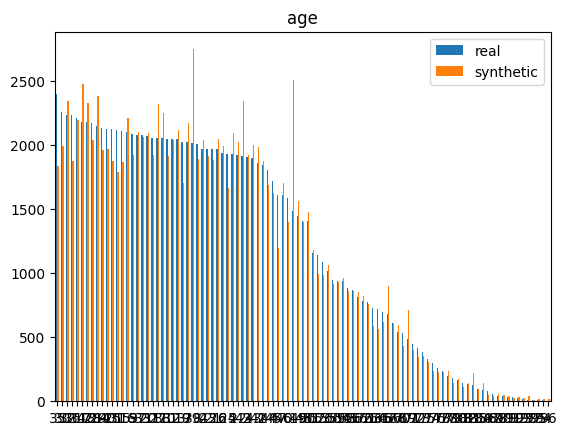

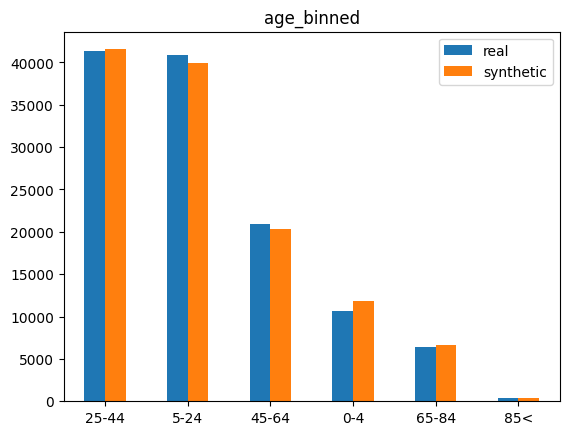

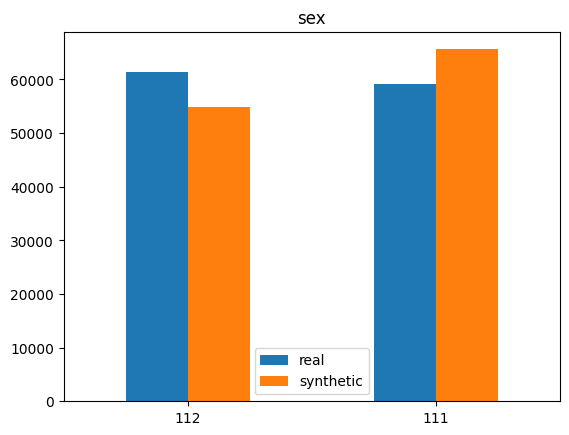

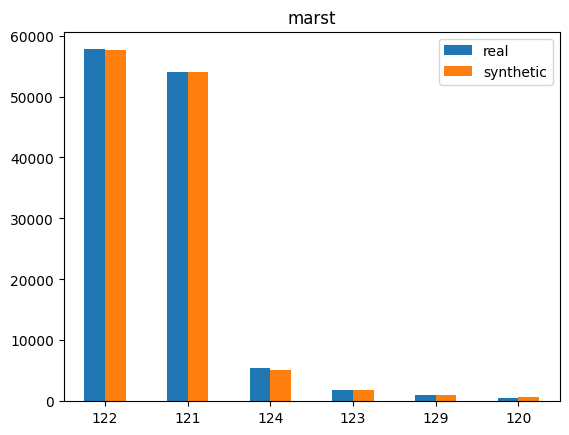

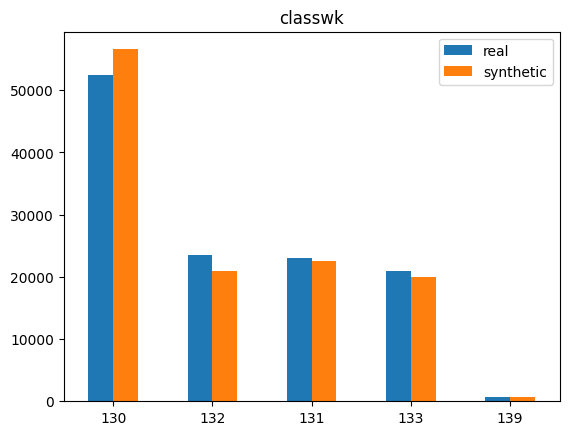

In [ ]:
compare_attributes(df1=sampled_df, df2=df,
                   columns_to_plot=['age', 'age_binned', 'sex', 'marst', 'classwk'],
                   legend_labels=['real', 'synthetic'])